# L1 and L2 regularization
You would have seen from the previous two assignments that training accuracy on cat classification was much higher (around 99%) compared to test accuracy (around 70%). Clearly this is a case of low bias high variance or overfitting. In this assignment you will attempt to improve the accuracy of the earlier model using regularization.

Let's import the required packages. Note that we have moved functions like initialize_params, forward, f, df, predict and test_model into assign2_utils.py.

In [1]:
import numpy as np
import argparse # for command-line parsing
import matplotlib # for plotting
from matplotlib import pyplot as plt # for plotting
from tqdm import tqdm_notebook as tqdm
from assign2_utils import load_train_data, load_test_data, flatten, initialize_params, forward
from assign2_utils import df, update_params, test_model 

%matplotlib inline 

In the last two assignments we had initialized many hyperparameters and variables in the main function that trains the model. We will make a few changes in this assignment. First, we will use argparse module and make  hyperparameters/variables as command line arguments. Second, we will rename main to train. The new main function in this assignment will train the model and then test it on the test set.

The below code adds some of the hyperparameters and variables as command-line arguments. The help keyword argument of add_argument method gives information about the hyperparameter/variable added as command-line argument.

In [2]:
# instantiate the ArgumentParser object; note that argparse had already been imported
parser = argparse.ArgumentParser(description='Train a fully connected network with regularization')

# add arguments
parser.add_argument('--miter', metavar='N', type=int, default=200, help='max number of iterations to train')
parser.add_argument('--alpha', metavar='LEARNING_RATE', type=float, default=0.001, help='initial learning rate')
parser.add_argument('--epsilon', metavar='EPSILON', type=float, default=1e-6)
parser.add_argument('--nl', metavar='N', default=2, type=int, help='number of layers')
parser.add_argument('--nx', metavar='LIST', nargs='+', type=int, default=[32, 1], help='num of nodes in each layer')
parser.add_argument('--fname_list', metavar='LIST', nargs='+', default=['ReLU', 'Sigmoid'], 
                    choices=['ReLU', 'Sigmoid', 'Tanh', 'Linear'], help='non-linearity to be applied at each layer')
parser.add_argument('--reg_method', metavar='LIST', nargs='+', default=['L2', 'L2'],
                    choices=['NoReg', 'L2', 'L1'], help='regularization to be applied at each layer (excluding ip layer)')
parser.add_argument('--lamda', metavar='LAMBDA', type=float, default=1., help='regularization parameter')

# parse the arguments. 
# Since we cannot invoke the code written in jupyter directly from command-line, 
# we can specify the required arguments in the call to parse_args as shown below with other arguments 
# left out to use their default values.
args = parser.parse_args('--miter 8000 --alpha .0065 --lamda 4.5 '.split()) # you may play with this code by changing
                                                                        # the arguments as required
print(args.nx)

[32, 1]


You can see from the previous cell that number of layers, number of nodes in each layer, regularization method to be applied at each layer, regularization constant etc. are passed as command-line arguments. When there is regularization at a layer, the derivative of loss with respect to weights at that layer will have an added term because of the regularization. You may look at the lecture notes for clarity on this. Below you will complete the blanks in backward method, train method and main method.

In [3]:
def backward(da, cache, fname = 'ReLU', reg_method = 'L2'):
    """
      Backward propagates da through the current layer given da, cache and the non-linearity at the current layer
      
      da: derivative of loss with respect current layers activation a; shape is nx[l] x m
      cache: a tuple that contains current layer's linear computation z, previous layer's activation aprev,
                     current layer's activation a and weight matrix W between previous layer l-1 and current layer l
      fname: name of the non-linearity at current layer l; this will be helpful for local gradient computation in 
             chain rule
      reg_method: regularization method that was applied at this layer
      
      returns dW: derivative of loss with respect to W; shape is nx[l] x nx[l-1]
              db: derivative of loss with respect to b; shape is nx[l] x 1
    """
    m = da.shape[1]
    z, aprev, a, W = cache       # extract from cache
    
    # replace ... with your answer
    dz = da * df(z, fname)      # compute dz as incoming grad da * local grad. For local grad, function df defined be useful
    dW = np.matmul(dz, aprev.T)  # np.dot or np.amtmul or @ operator will be useful. Also .T will be useful for 
                                 # transposing
        
    # add derivative of regularization penalty at this layer w.r.to W to dW
    # replace ... with your answer
    if reg_method == 'NoReg':     # no regularization
        dW += 0  # one line of code
    elif reg_method == 'L1':      # L1 regularization
        sgn_w = np.sign(W)
        sgn_w[sgn_w == 0] = 1
        dW += (args.lamda/m) * sgn_w  # few lines (atmost 4) of code; np.sign will be useful
    elif reg_method == 'L2':
        dW +=  (args.lamda/m) * W          # one line of code; 
    else:
        raise ValueError('Unkown regularization method')
        
    # replace ... with your answer
    db = np.sum(dz, axis = 1, keepdims=True)      # np.sum will be useful
    daprev = W.T @ dz            # np.dot or np.amtmul or @ operator will be useful. Also .T will be useful for 
                                 # transposing
    return daprev, dW, db


def train(a0, y, Wlist, blist): # main function to train and test the model  
    """
      Given the input and the labels, this function trains the model
      
      a0: Input which is a numpy array of shape (nx[0], m); m is the number of samples; nx[0] is num of features
      y: label which is a numpy array of shape (m, )
      Wlist: a list of all weight matrices
      blist: a list of bias vectors
      
      returns None      
    """
    
    # set number of training examples to m
    m = a0.shape[1]
    epsilon = 1e-6
   
    # initialize list of caches for each layer, gradients of weights at each layer, gradients of biases at
    # each layer to empty
    cache, dWlist, dblist = ([None]*args.nl for i in range(3))
    dw_list = [[0] * args.miter, [0] * args.miter, [0] * args.miter, [0] * args.miter]
    
    for i in tqdm(range(args.miter)):
        a = a0
        # forward propagate through each layer
        for l in range(args.nl):
            # replace ... with your answer
            a, cache[l] = forward(a, Wlist[l], blist[l], args.fname_list[l])     # call forward function with appropriate arguments
            
        # replace ... with your answer
        L = (-1/m) * np.sum((y * np.log(a) + (1-y) * np.log(1-a)))  # compute loss
                
        # Add regularization penalty to loss; replace ... with your answer
        for l in range(args.nl):
            if args.reg_method[l] == 'NoReg':
                L += 0 # one line of code
            elif args.reg_method[l] == 'L1':
                L += (args.lamda/m) * np.linalg.norm(Wlist[l], ord=1)
            elif args.reg_method[l] == 'L2':
                L += (args.lamda/(2*m)) * np.power(np.linalg.norm(Wlist[l]),2)  ########  HERE USE FROBINIUS NORM      ######
            else:
                raise ValueError('Unknown regularization method error')
                
        # compute da
        # replace ... with your answer
#         print("SAI: ", L.shape)
        da = (1/m) * (a-y) * (1/((a * (1-a)) + epsilon)) # not affected by regularization penalty
        
        # backward propagate through each layer to compute gradients
        for l in range(args.nl-1, -1, -1):
            # replace ... by your answer 
            da, dWlist[l], dblist[l] = backward(da, cache[l], args.fname_list[l], args.reg_method[l]) # call backward function with appropriate arguments                                                 
            dw_list[l][i] = np.linalg.norm(dWlist[l])
        
        # update_params
        # call update_params function with appropriate arguments
        update_params(Wlist, blist, dWlist, dblist, args.alpha) 
        
        if not i%100: # print loss every 100 iterations
                print(f'Loss at iteration {i}:\t{np.asscalar(L):.4f}')
#                 for l in range(args.nl):
#                     print("norm(dW)",l, ": ", np.linalg.norm(dWlist[l]))
    return    

In [4]:
def main(): # main function to train and test the model
    
    # certain assertions
    assert args.nl >= 2, 'Number of layers in the network should be atleast 2 excluding ip layer.'
    assert len(args.nx) == args.nl, '''Excluding ip layer, number of nodes for each layer must be specified.
                                             Not more, not less.'''
    assert len(args.fname_list) == args.nl, '''Non-linearities to be applied at each layer must be 
                                                         specified, excluding input layer. Not more, not less.'''
    assert len(args.reg_method) == args.nl, '''Requirement of regularization must be mentioned for 
                                               every layer, excluding ip layer. Not more, not less.'''
    
    # load train data
    a0, y = load_train_data()
    a0 = flatten(a0)
    a0 = a0/255. # normalize the data to [0, 1]     
    
    # insert num of features in i/p layers to args.nodelist
    args.nx.insert(0, a0.shape[0])    
    
    # initialize weights and biases
    Wlist, blist = initialize_params(args.nx)
    
    # train the model
    train(a0, y, Wlist, blist)
    
    # test the model
    print(f'train accuracy: {test_model(a0, y, Wlist, blist, args.fname_list) * 100:.2f}%')

    x, y = load_test_data()
    x = flatten(x)
    x = x/255. # normalize the data to [0, 1]
    print(f'test accuracy: {test_model(x, y, Wlist, blist, args.fname_list) * 100:.2f}%')
    
    return
    
if __name__ == '__main__':
    main()

Loss at iteration 0:	1.1194
Loss at iteration 100:	1.0571
Loss at iteration 200:	1.0317
Loss at iteration 300:	0.9951
Loss at iteration 400:	0.9504
Loss at iteration 500:	0.9000
Loss at iteration 600:	0.8430
Loss at iteration 700:	0.7835
Loss at iteration 800:	0.7257
Loss at iteration 900:	0.6756
Loss at iteration 1000:	0.6445
Loss at iteration 1100:	0.6202
Loss at iteration 1200:	0.5932
Loss at iteration 1300:	0.5414
Loss at iteration 1400:	0.4929
Loss at iteration 1500:	0.4779
Loss at iteration 1600:	0.4394
Loss at iteration 1700:	0.4192
Loss at iteration 1800:	0.4079
Loss at iteration 1900:	0.3878
Loss at iteration 2000:	0.3773
Loss at iteration 2100:	0.3653
Loss at iteration 2200:	0.3551
Loss at iteration 2300:	0.3457
Loss at iteration 2400:	0.3378
Loss at iteration 2500:	0.3300
Loss at iteration 2600:	0.3225
Loss at iteration 2700:	0.3156
Loss at iteration 2800:	0.3089
Loss at iteration 2900:	0.3028
Loss at iteration 3000:	0.2968
Loss at iteration 3100:	0.2912
Loss at iteration 32

# Questions

1. Did regularization have any effect at all? If not why? If yes, which regularization did better?

#### Ans: We see that regularization doesn't have the desired effect. So, we can say that the overfitting is not due to noise but mostly due to lack of representative samples in the training set.

2. Split the train data into 90% train data and 10% valid data randomly. For every training iteration, compute validation loss and validation accuracy. Plot train loss, valid loss, train accuracy and valid accuracy against the number of iterations. Make your observations based on these plots. For splitting, np.random.shuffle and np.random.randint may be helpful.

In [5]:
def train_with_loss(a0, y, valid_data, valid_labels, Wlist, blist):

    train_loss = [None] * args.miter
    valid_loss = [None] * args.miter
    train_accr = [None] * args.miter
    valid_accr = [None] * args.miter
    
    m = a0.shape[1]
    m1 = valid_data.shape[1]
    epsilon = 1e-6
   
    cache, cache1, dWlist, dblist = ([None]*args.nl for i in range(4))
    
    for i in tqdm(range(args.miter)):
        # FORWARD pass training data
        a = a0
        for l in range(args.nl):
            a, cache[l] = forward(a, Wlist[l], blist[l], args.fname_list[l])     
            
        L = (-1/m) * np.sum((y * np.log(a) + (1-y) * np.log(1-a)))
        
        
        # FORWARD pass for validation data
        a1 = valid_data
        for l in range(args.nl):
            a1, cache1[l] = forward(a1, Wlist[l], blist[l], args.fname_list[l])
        
        L_valid = (-1/m1) * np.sum((valid_labels * np.log(a1) + (1-valid_labels) * np.log(1-a1)))         
        
        
        for l in range(args.nl):
            if args.reg_method[l] == 'NoReg':
                L += 0
                L_valid += 0
            elif args.reg_method[l] == 'L1':
                L += (args.lamda/m) * np.linalg.norm(Wlist[l], ord=1)
                L_valid += (args.lamda/m1) * np.linalg.norm(Wlist[l], ord=1)
            elif args.reg_method[l] == 'L2':
                L += (args.lamda/(2*m)) * np.power(np.linalg.norm(Wlist[l]),2)  
                L_valid += (args.lamda/(2*m1)) * np.power(np.linalg.norm(Wlist[l]),2)  
            else:
                raise ValueError('Unknown regularization method error')
                
        da = (1/m) * (a-y) * (1/((a * (1-a)) + epsilon)) 
        
        for l in range(args.nl-1, -1, -1):
            da, dWlist[l], dblist[l] = backward(da, cache[l], args.fname_list[l], args.reg_method[l]) 

        update_params(Wlist, blist, dWlist, dblist, args.alpha) 
        
        train_loss[i] = L
        train_accr[i] = test_model(a0, y, Wlist, blist, args.fname_list) * 100
        valid_loss[i] = L_valid
        valid_accr[i] = test_model(valid_data, valid_labels, Wlist, blist, args.fname_list) * 100
        if not i%100: 
                print(f'Loss at iteration {i}:\t{np.asscalar(L):.8f}')
                
    return train_loss, train_accr, valid_loss, valid_accr


In [6]:
train_valid_split = 10     # percentage of data for validation


a0, y = load_train_data()
a0 = flatten(a0)
a0 = a0/255. # normalize the data to [0, 1]     

y1 = np.reshape(y, (1,209))
# print(a0.shape, y1.shape)
x = np.append(arr=a0, axis=0, values=y1)
print(x.shape)
x = x.T
np.random.shuffle(x)
X = x.T
x_valid = X[:, :int(209 * train_valid_split / 100)]
x_train = X[:,int(209 * train_valid_split / 100):]
train_labels = x_train[12288:,]
valid_labels = x_valid[12288:,]
# tmp = x[:,0]
print(X.shape)

train_labels = np.reshape(train_labels, (train_labels.shape[1],))
valid_labels = np.reshape(valid_labels, (valid_labels.shape[1],))
x_train = np.delete(arr=x_train, obj=12288, axis=0)
x_valid = np.delete(arr=x_valid, obj=12288, axis=0)

print(x_train.shape, train_labels.shape)
print(x_valid.shape, valid_labels.shape)

# validation_indices = np.random.randint(0, 209, 209 * train_valid_split)
# valid_data = [None 

(12289, 209)
(12289, 209)
(12288, 189) (189,)
(12288, 20) (20,)


In [7]:
a0 = x_train
# insert num of features in i/p layers to args.nodelist

# args.nx.insert(0, a0.shape[0])    
# initialize weights and biases
Wlist, blist = initialize_params(args.nx)

# train the model
train_loss, train_accr, valid_loss, valid_accr = train_with_loss(a0, train_labels, x_valid, valid_labels, Wlist, blist)

# test the model
print(f'train accuracy: {test_model(a0, train_labels, Wlist, blist, args.fname_list) * 100:.2f}%')
x, y = load_test_data()
x = flatten(x)
x = x/255. # normalize the data to [0, 1]
print(f'test accuracy: {test_model(x, y, Wlist, blist, args.fname_list) * 100:.2f}%')

Loss at iteration 0:	1.16650175
Loss at iteration 100:	1.10001964
Loss at iteration 200:	1.07274304
Loss at iteration 300:	1.03299427
Loss at iteration 400:	0.98441755
Loss at iteration 500:	0.93449022
Loss at iteration 600:	0.87561971
Loss at iteration 700:	0.81255376
Loss at iteration 800:	0.75464543
Loss at iteration 900:	0.70429822
Loss at iteration 1000:	0.67075505
Loss at iteration 1100:	0.62484294
Loss at iteration 1200:	0.62071863
Loss at iteration 1300:	0.55944274
Loss at iteration 1400:	0.51108216
Loss at iteration 1500:	0.48181063
Loss at iteration 1600:	0.46719809
Loss at iteration 1700:	0.44503831
Loss at iteration 1800:	0.42124108
Loss at iteration 1900:	0.40702195
Loss at iteration 2000:	0.39372972
Loss at iteration 2100:	0.38036180
Loss at iteration 2200:	0.36952997
Loss at iteration 2300:	0.35961373
Loss at iteration 2400:	0.35029917
Loss at iteration 2500:	0.34219030
Loss at iteration 2600:	0.33424648
Loss at iteration 2700:	0.32619823
Loss at iteration 2800:	0.318862

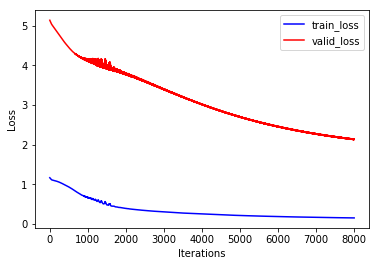

In [8]:
x_axis = [i for i in range(1, args.miter+1)]
plt.plot(x_axis, train_loss, 'b', label='train_loss')
plt.plot(x_axis, valid_loss, 'r', label='valid_loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

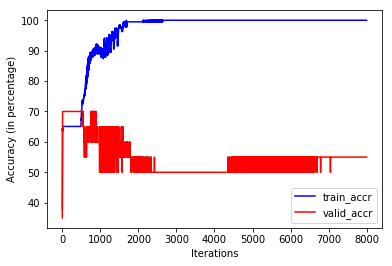

In [9]:
plt.plot(x_axis, train_accr, 'b', label='train_accr')
plt.plot(x_axis, valid_accr, 'r', label='valid_accr')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (in percentage)')
plt.legend()
plt.show()

#### We see that both the train loss and the validation loss decreases but validation loss remains much higher than the train loss.
#### For the train and validation accuracies, we observe that initially they improve very sharply followed by some variations. Then, after touching their peak values, validation loss strarts to vary a lot fall showing over-fitting.

Note: All questions will be answered in the jupyter notebook only. Wherever code is required you write and run the code in a code cell. For text, write and render in a markdown cell.